In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install xgboost==1.3.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 157.5 MB 55 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [ ]:
import joblib

def logistic_regression():
    return joblib.load(r"/content/drive/MyDrive/AutoEncoders/lr_file_encoder.pkl")

def passive_aggressive_classifier():
    return joblib.load(r"/content/drive/MyDrive/AutoEncoders/pac_file_encoder.pkl")

def decision_tree():
    return joblib.load(r"/content/drive/MyDrive/AutoEncoders/dt_file_encoder.pkl")

def gradient_boosting():
    return joblib.load(r"/content/drive/MyDrive/AutoEncoders/gb_file_encoder.pkl")

def adaptive_gradient_boosting():
    return joblib.load(r"/content/drive/MyDrive/AutoEncoders/adb_file_encoder.pkl")

def extreme_gradient_boosting():
    return joblib.load(r"/content/drive/MyDrive/AutoEncoders/xgb_file_encoder.pkl")

def light_gradient_boosting():
    return joblib.load(r"/content/drive/MyDrive/AutoEncoders/lgbm_file_encoder.pkl")

def voting_classifier():
    return joblib.load(r"/content/drive/MyDrive/AutoEncoders/voting_file_encoder.pkl")

In [ ]:
lr_model=logistic_regression()
pac_model=passive_aggressive_classifier()
dt_model=decision_tree()
gb_model=gradient_boosting()
adb_model=adaptive_gradient_boosting()
xgb_model=extreme_gradient_boosting()
lgbm_model=light_gradient_boosting()
voting_model=voting_classifier()

In [ ]:
!pip install bnlp-toolkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 4.2 MB/s 
     |████████████████████████████████| 23.9 MB 1.3 MB/s 
     |████████████████████████████████| 965 kB 53.5 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
import pandas as pd
import numpy as np
import re
from bnlp.corpus import stopwords
from sklearn.feature_extraction.text import HashingVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import *
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set()

punkt not found. downloading...


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [ ]:
label_auth=pd.read_csv(r'/content/drive/MyDrive/AutoEncoders/LabeledAuthentic-7K.csv') #, nrows=3067)
label_fake=pd.read_csv(r'/content/drive/MyDrive/AutoEncoders/LabeledFake-1K.csv') #, nrows=995)
label_auth.drop(['source','relation'], axis=1, inplace=True)
label_fake.drop(['source','relation','F-type'], axis=1, inplace=True)
df=pd.concat([label_auth, label_fake], axis=0)
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)
df['label']=np.where(df['label']==0.0, 0, 1)
df.tail()
df=df.sample(frac=1).reset_index(drop=True)
print(df.shape)
df.head()

(8501, 7)


,articleID,domain,date,category,headline,content,label
0,6089,kalerkantho.com,2018-09-20 09:25:56,National,সিনিয়র সচিব হলেন ছয় কর্মকর্তা,আরো ছয় সচিবকে সিনিয়র সচিব করা হয়েছে। গতকাল বুধ...,1
1,3072,dailynayadiganta.com,2018-09-19 23:50:26,National,শিক্ষার্থীদের পেটানোর অভিযোগে প্রধান শিক্ষককে ...,রাজবাড়ীর বালিয়াকান্দি সদর ইউনিয়নের বকচর সরকারী...,1
2,457,risingbd.com,2018-09-20 17:17:09,International,গরুকে ‘জাতির মাতা’ ঘোষণার দাবি,আন্তর্জাতিক ডেস্ক : গরুকে ‘জাতির মা’ ঘোষণার প্...,1
3,2906,banglanews24.com,2018-09-22 14:00:52,Sports,শেষ ভরসা মাহমুদউল্লাহ’র পর মোসাদ্দেকের বিদায়,৬৫ রানে ৫ উইকেট পড়ে যাওয়ার পর হাল ধরেছিলেন মাহ...,1
4,519,earki.com,"১৬:২৫, জানুয়ারি ০২, ২০১৯",Politics,আরেকটু হলেই বহিষ্কৃত হওয়ার রেকর্ড গড়বেন জাতীয় ...,"দার্শনিক এরিস্টটল এরশাদ সম্পর্কে বলেছিলেন, 'ঢা...",0


In [ ]:
def preprocess(data):
    """This function is for preprocessing of the news contents. It removes punctuations, English characters and both of Bangla
    and English numerals. It tokenizes all the words and also removes stopwords.
    
    Args: 
        The Entire Dataframe
    Returns:
        Preprocessed news corpuses in a list of lists
    """
    corpus=[]
    for i in range(0, len(data)):
        x=re.sub('[^\u0980-\u09FF]',' ',data['content'][i])
        x=re.sub('[a-zA-Z0-9]+', ' ', x)
        x=re.sub('[০১২৩৪৫৬৭৮৯]+', ' ', x)
        x=x.split()
        x=[w for w in x if w not in set(stopwords)]
        x=' '.join(x)
        corpus.append(x)
    
    return corpus


corpus=preprocess(df)
corpus[16:20]

['গণফোরাম নেতা ড কামাল হোসেনের নেতৃত্বাধীন জাতীয় ঐক্য প্রক্রিয়ার সমাবেশে যোগ দিচ্ছে বিএনপি বিএনপি মহাসচিব মির্জা ফখরুল ইসলাম আলমগীরসহ শীর্ষ পর্যায়ের কয়েকজন নেতা সমাবেশে সংহতি জানানোর কথা ঐক্য প্রক্রিয়ার আগের অনুষ্ঠানে যুক্তফ্রন্টের চেয়ারম্যান বদরুদ্দোজা চৌধুরীও যাচ্ছেন মহানগর নাট্যমঞ্চের সমাবেশে পনেরো সেপ্টেম্বর জাতীয় ঐক্য প্রক্রিয়ার সংবাদ সম্মেলন খুলনার সমাবেশে অংশ নেননি প্রক্রিয়ার অন্যতম নেতা বদরুদ্দোজা চৌধুরী অনুপস্থিতি বিতর্ক ওঠে নেতাদের ঐক্য আসলেই রাজনীতিতে মেরুকরণ ঘটাবে শনিবার রাজধানীর মহানগর নাট্যমঞ্চে জাতীয় ঐক্য প্রক্রিয়ার সমাবেশে উপস্থিত থাকার কথা রয়েছে জাতীয় ঐক্যের প্রক্রিয়াকে সমর্থন সমাবেশে যাবেন জানিয়েছেন বিএনপি নেতারাও দফা দাবি লক্ষ্যের আনুষ্ঠানিক ঘোষনা দেয়ার জাতীয় ঐক্যের নেতারা গ্রহণযোগ্য নির্বাচন অনুষ্ঠানের সরকার বিরোধী রাজনৈতিক দলগুলোকে ঐক্যবদ্ধ এইচ',
 'কুমিল্লার নববিবাহিত যুবক সোহেলকে শ্বশুর বাড়ি ইফতারির দাওয়াত দিলে সস্ত্রীক উপস্থিত ইফতারের আইটেম সোহেল নব শ্বশুর শাশুড়ির সুনামও আক্ষরিক অর্থে তেলবাজি ইফতারের বাকি আইটেম থাকলেও বেগুনি খেতে সোহেল হঠাৎ টের পান বেগুনিতে বেগুন

In [ ]:
hashing=HashingVectorizer(n_features=5000, ngram_range=(1, 3))
X=hashing.fit_transform(corpus).toarray()
y=df['label'].values
X.shape, y.shape

((8501, 5000), (8501,))

In [ ]:
from tensorflow.keras.models import load_model
encoder=load_model('/content/drive/MyDrive/AutoEncoders/encoder_eff.h5')

In [ ]:
X_encode=encoder.predict(X)

In [ ]:
X

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.05735393],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.02708645,  0.        ]])

In [ ]:
X_encode

array([[ 0.00026394, -0.00207861, -0.0095326 , ...,  0.00577367,
        -0.00791307, -0.00387299],
       [-0.00203935,  0.00637369, -0.00901681, ...,  0.0002897 ,
         0.00231104, -0.0004268 ],
       [ 0.00098357, -0.00521643, -0.00698461, ..., -0.0055518 ,
         0.00149893,  0.00413304],
       ...,
       [-0.00207426, -0.00449173, -0.00068652, ...,  0.00194129,
        -0.00673772, -0.00064643],
       [-0.00232341,  0.00199064,  0.0073348 , ...,  0.00888236,
         0.00227345, -0.00017478],
       [ 0.00227752, -0.00689236, -0.00428727, ...,  0.00354063,
         0.00462785, -0.00544045]], dtype=float32)

In [ ]:
lr_pred=lr_model.predict(X_encode)
pac_pred=pac_model.predict(X_encode)
dt_pred=dt_model.predict(X_encode)
gb_pred=gb_model.predict(X_encode)
adb_pred=adb_model.predict(X_encode)
xgb_pred=xgb_model.predict(X_encode)
lgbm_pred=lgbm_model.predict(X_encode)
voting_pred=voting_model.predict(X_encode)

In [ ]:
print(f'Actual Outcomes ---> {y[:10]}')
print(f'Prediction Outcomes in Logistic Regression Model ---> {lr_pred[:10]}')
print(f'Prediction Outcomes in Passive Aggressive Classifier Model ---> {pac_pred[:10]}')
print(f'Prediction Outcomes in Decision Tree Model ---> {dt_pred[:10]}')
print(f'Prediction Outcomes in Gradient Boosting Model ---> {gb_pred[:10]}')
print(f'Prediction Outcomes in Adaptive Gradient Boosting Model ---> {adb_pred[:10]}')
print(f'Prediction Outcomes in Extreme Gradient Boosting Model ---> {xgb_pred[:10]}')
print(f'Prediction Outcomes in Light Gradient Boosted Machine Model ---> {lgbm_pred[:10]}')
print(f'Prediction Outcomes in Voting Classifier(lr+pac+dt+light) Model ---> {voting_pred[:10]}')

Actual Outcomes ---> [1 1 1 1 0 1 1 0 1 1]
Prediction Outcomes in Logistic Regression Model ---> [1 1 1 1 0 1 1 0 1 1]
Prediction Outcomes in Passive Aggressive Classifier Model ---> [1 1 1 1 0 1 1 0 1 1]
Prediction Outcomes in Decision Tree Model ---> [1 1 1 1 1 1 1 0 1 1]
Prediction Outcomes in Gradient Boosting Model ---> [1 1 1 1 0 1 1 0 1 1]
Prediction Outcomes in Adaptive Gradient Boosting Model ---> [1 1 1 1 0 1 1 0 1 1]
Prediction Outcomes in Extreme Gradient Boosting Model ---> [1 1 1 1 1 1 1 0 1 1]
Prediction Outcomes in Light Gradient Boosted Machine Model ---> [1 1 1 1 1 1 1 0 1 1]
Prediction Outcomes in Voting Classifier(lr+pac+dt+light) Model ---> [1 1 1 1 0 1 1 0 1 1]


In [ ]:
def model_accuracy(pred):
  return accuracy_score(y, pred)

lr_accuracy=model_accuracy(lr_pred).round(2)
pac_accuracy=model_accuracy(pac_pred).round(2)
dt_accuracy=model_accuracy(dt_pred).round(2)
gb_accuracy=model_accuracy(gb_pred).round(2)
adb_accuracy=model_accuracy(adb_pred).round(2)
xgb_accuracy=model_accuracy(xgb_pred).round(2)
lgbm_accuracy=model_accuracy(lgbm_pred).round(2)
voting_accuracy=model_accuracy(voting_pred).round(2)

accuracy_scores={'Models Used':['Logistic Regression', 'Passive Aggressive Classifier', 'Decision Tree', 'Gradient Boosting', 'Adaptive Gradient Boosting', 'Extreme Gradient Boosting', 'Light Gradient Boosted Machine', 'Voting Classifier(lr+pac+dt+light)'],
                 'Accuracy':[lr_accuracy, pac_accuracy, dt_accuracy, gb_accuracy, adb_accuracy, xgb_accuracy, lgbm_accuracy, voting_accuracy]}

df_acc=pd.DataFrame(accuracy_scores)
df_acc

,Models Used,Accuracy
0,Logistic Regression,0.98
1,Passive Aggressive Classifier,0.93
2,Decision Tree,0.90
3,Gradient Boosting,0.95
4,Adaptive Gradient Boosting,0.93
5,Extreme Gradient Boosting,0.93
6,Light Gradient Boosted Machine,0.92
7,Voting Classifier(lr+pac+dt+light),0.95


In [ ]:
df_acc=df_acc.sort_values('Accuracy')
df_acc

,Models Used,Accuracy
2,Decision Tree,0.90
6,Light Gradient Boosted Machine,0.92
1,Passive Aggressive Classifier,0.93
4,Adaptive Gradient Boosting,0.93
5,Extreme Gradient Boosting,0.93
3,Gradient Boosting,0.95
7,Voting Classifier(lr+pac+dt+light),0.95
0,Logistic Regression,0.98


In [ ]:
df_acc.to_csv('/content/drive/MyDrive/CSE-400(Project Thesis)/Accuarcy_ML_hashing.csv', index=False)

In [ ]:
acc_df=df_acc.set_index('Models Used')
acc_df

,Accuracy
Models Used,
Decision Tree,0.90
Light Gradient Boosted Machine,0.92
Passive Aggressive Classifier,0.93
Adaptive Gradient Boosting,0.93
Extreme Gradient Boosting,0.93
Gradient Boosting,0.95
Voting Classifier(lr+pac+dt+light),0.95
Logistic Regression,0.98


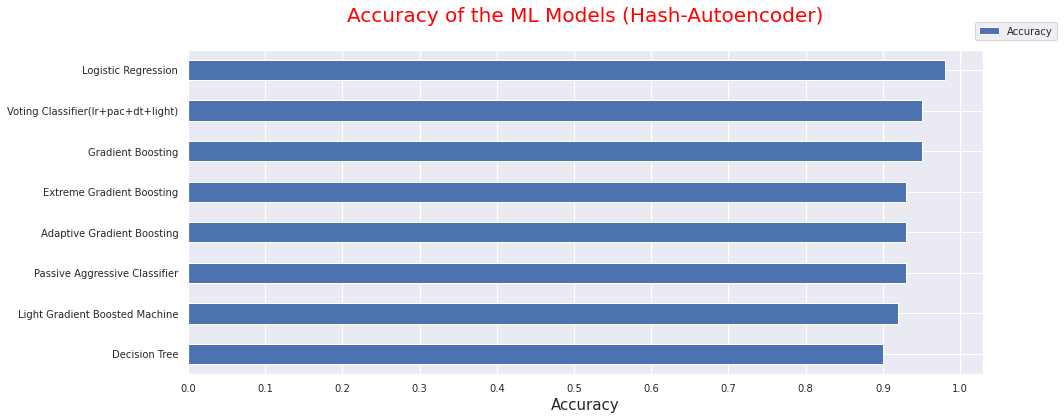

In [ ]:
acc_df.plot.barh(figsize=(15, 6));
plt.ylabel('')
plt.xlabel('Accuracy', fontsize=15)
plt.title('Accuracy of the ML Models (Hash-Autoencoder)\n', fontsize=20, color='red')
plt.legend(bbox_to_anchor=(1.1, 1.1), fontsize=10)
plt.xticks([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0], fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
cm=confusion_matrix(y, lr_pred)
recall=np.diag(cm) / np.sum(cm, axis=1)
precision=np.diag(cm) / np.sum(cm, axis=0)
label_names=['fake', 'real']
df_cm=pd.DataFrame(cm, index=label_names, columns=label_names)
df_cm

,fake,real
fake,1178,121
real,26,7176


In [ ]:
fake_recall=recall[0].round(2)
fake_precision=precision[0].round(2)
fake_f1_score=(2*fake_recall*fake_precision)/(fake_recall+fake_precision)
fake_f1_score

0.9437037037037037

In [ ]:
def fake_news_performance(pred, model_name=''):
  cm=confusion_matrix(y, pred)
  recall=np.diag(cm) / np.sum(cm, axis=1)
  precision=np.diag(cm) / np.sum(cm, axis=0)
  fake_recall=recall[0].round(2)
  fake_precision=precision[0].round(2)
  fake_f1_score=(2*fake_recall*fake_precision)/(fake_recall+fake_precision)
  fake_f1_score=fake_f1_score.round(2)
  label_names=['fake', 'real']
  df_cm=pd.DataFrame(cm, index=label_names, columns=label_names)
  plt.figure(figsize=(15, 6))
  sns.heatmap(df_cm, annot=True, annot_kws={"size": 20}, fmt='g')
  plt.xticks(fontsize=25)
  plt.yticks(rotation=0, fontsize=25)
  plt.title('\nConfusion Matrix for '+model_name+' (Hash-Autoencoder)\n', fontsize=30, color='red')
  plt.show()
    
  print('-----------------------------------------------------------------------------------------------------------------')
  print(f'\nClassification Report for:--> {model_name} (Hash-Autoencoder) \n{classification_report(y, pred, target_names=label_names)}')

  return fake_precision, fake_recall, fake_f1_score

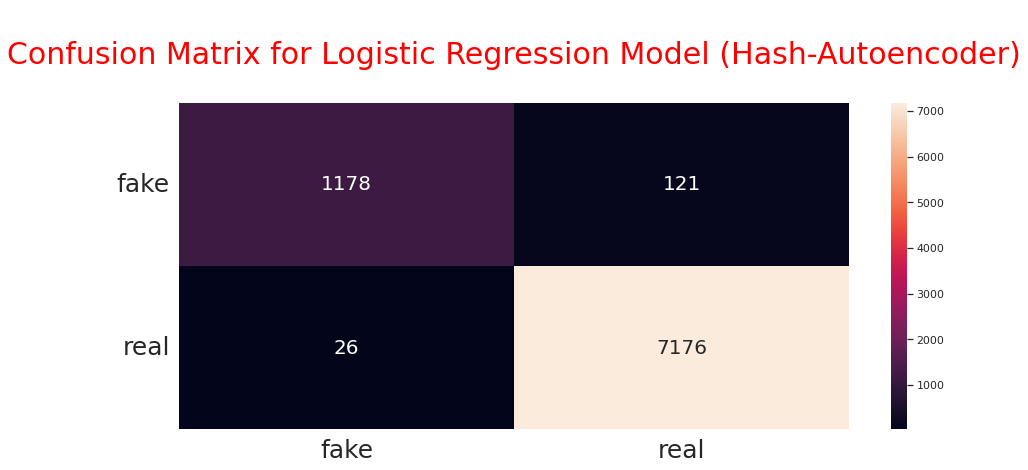

-----------------------------------------------------------------------------------------------------------------

Classification Report for:--> Logistic Regression Model (Hash-Autoencoder) 
              precision    recall  f1-score   support

        fake       0.98      0.91      0.94      1299
        real       0.98      1.00      0.99      7202

    accuracy                           0.98      8501
   macro avg       0.98      0.95      0.97      8501
weighted avg       0.98      0.98      0.98      8501



In [ ]:
fake_precision_lr, fake_recall_lr, fake_f1_score_lr=fake_news_performance(lr_pred, 'Logistic Regression Model')

In [ ]:
print(f'Precision, Recall and F1 Score for Fake News Classification using Logistic Regression Model --> {fake_precision_lr, fake_recall_lr, fake_f1_score_lr}, respectively')

Precision, Recall and F1 Score for Fake News Classification using Logistic Regression Model --> (0.98, 0.91, 0.94), respectively


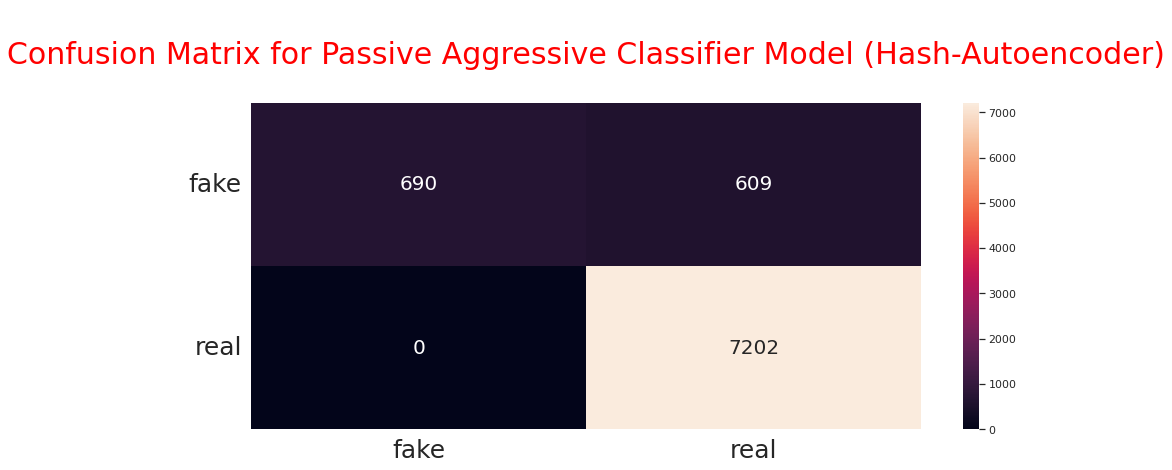

-----------------------------------------------------------------------------------------------------------------

Classification Report for:--> Passive Aggressive Classifier Model (Hash-Autoencoder) 
              precision    recall  f1-score   support

        fake       1.00      0.53      0.69      1299
        real       0.92      1.00      0.96      7202

    accuracy                           0.93      8501
   macro avg       0.96      0.77      0.83      8501
weighted avg       0.93      0.93      0.92      8501



In [ ]:
fake_precision_pac, fake_recall_pac, fake_f1_score_pac=fake_news_performance(pac_pred, 'Passive Aggressive Classifier Model')

In [ ]:
print(f'Precision, Recall and F1 Score for Fake News Classification using Passive Aggressive Classifier Model --> {fake_precision_pac, fake_recall_pac, fake_f1_score_pac}, respectively')

Precision, Recall and F1 Score for Fake News Classification using Passive Aggressive Classifier Model --> (1.0, 0.53, 0.69), respectively


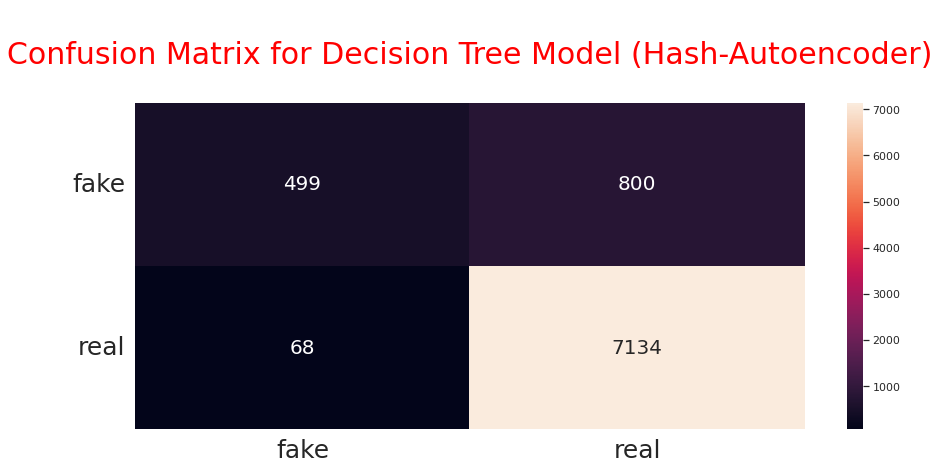

-----------------------------------------------------------------------------------------------------------------

Classification Report for:--> Decision Tree Model (Hash-Autoencoder) 
              precision    recall  f1-score   support

        fake       0.88      0.38      0.53      1299
        real       0.90      0.99      0.94      7202

    accuracy                           0.90      8501
   macro avg       0.89      0.69      0.74      8501
weighted avg       0.90      0.90      0.88      8501



In [ ]:
fake_precision_dt, fake_recall_dt, fake_f1_score_dt=fake_news_performance(dt_pred, 'Decision Tree Model')

In [ ]:
print(f'Precision, Recall and F1 Score for Fake News Classification using Decision Tree Model --> {fake_precision_dt, fake_recall_dt, fake_f1_score_dt}, respectively')

Precision, Recall and F1 Score for Fake News Classification using Decision Tree Model --> (0.88, 0.38, 0.53), respectively


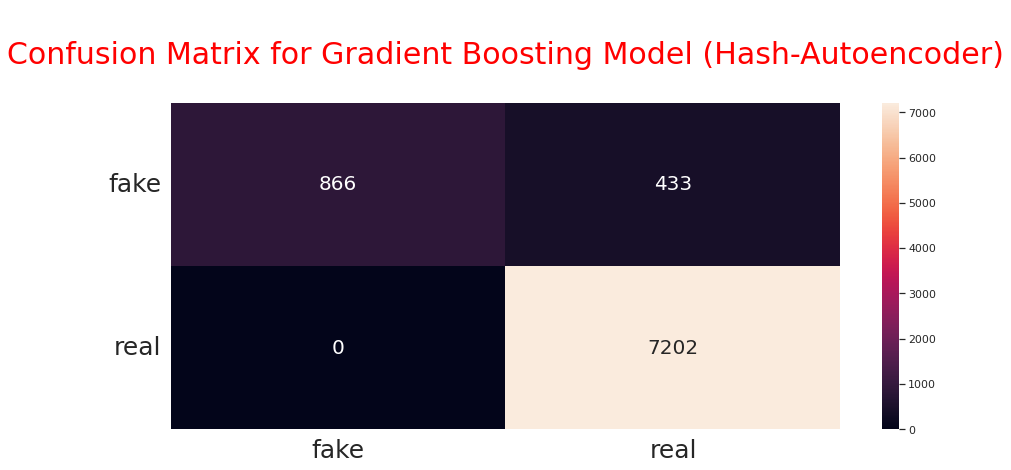

-----------------------------------------------------------------------------------------------------------------

Classification Report for:--> Gradient Boosting Model (Hash-Autoencoder) 
              precision    recall  f1-score   support

        fake       1.00      0.67      0.80      1299
        real       0.94      1.00      0.97      7202

    accuracy                           0.95      8501
   macro avg       0.97      0.83      0.89      8501
weighted avg       0.95      0.95      0.94      8501



In [ ]:
fake_precision_gb, fake_recall_gb, fake_f1_score_gb=fake_news_performance(gb_pred, 'Gradient Boosting Model')

In [ ]:
print(f'Precision, Recall and F1 Score for Fake News Classification using Gradient Boosting Model --> {fake_precision_gb, fake_recall_gb, fake_f1_score_gb}, respectively')

Precision, Recall and F1 Score for Fake News Classification using Gradient Boosting Model --> (1.0, 0.67, 0.8), respectively


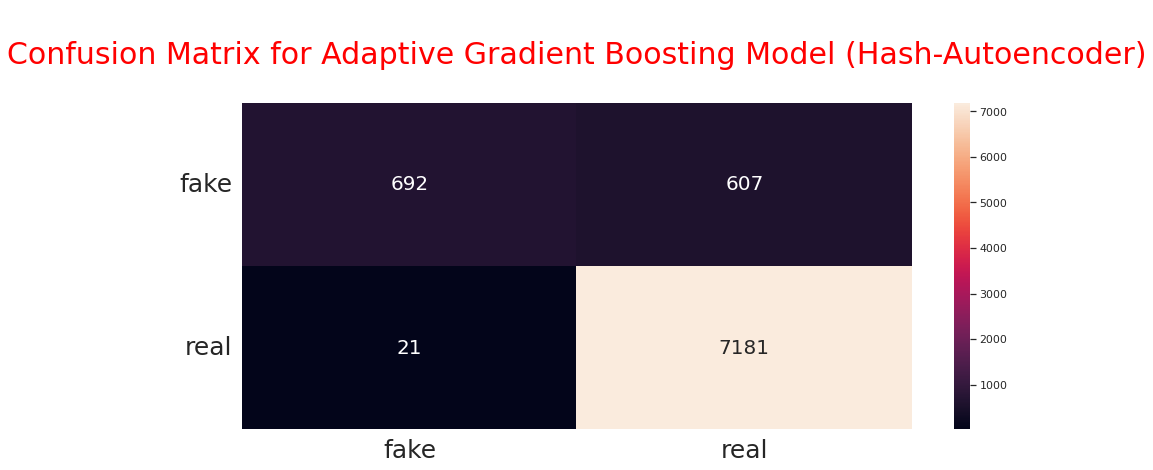

-----------------------------------------------------------------------------------------------------------------

Classification Report for:--> Adaptive Gradient Boosting Model (Hash-Autoencoder) 
              precision    recall  f1-score   support

        fake       0.97      0.53      0.69      1299
        real       0.92      1.00      0.96      7202

    accuracy                           0.93      8501
   macro avg       0.95      0.76      0.82      8501
weighted avg       0.93      0.93      0.92      8501



In [ ]:
fake_precision_adb, fake_recall_adb, fake_f1_score_adb=fake_news_performance(adb_pred, 'Adaptive Gradient Boosting Model')

In [ ]:
print(f'Precision, Recall and F1 Score for Fake News Classification using Adaptive Gradient Boosting Model --> {fake_precision_adb, fake_recall_adb, fake_f1_score_adb}, respectively')

Precision, Recall and F1 Score for Fake News Classification using Adaptive Gradient Boosting Model --> (0.97, 0.53, 0.69), respectively


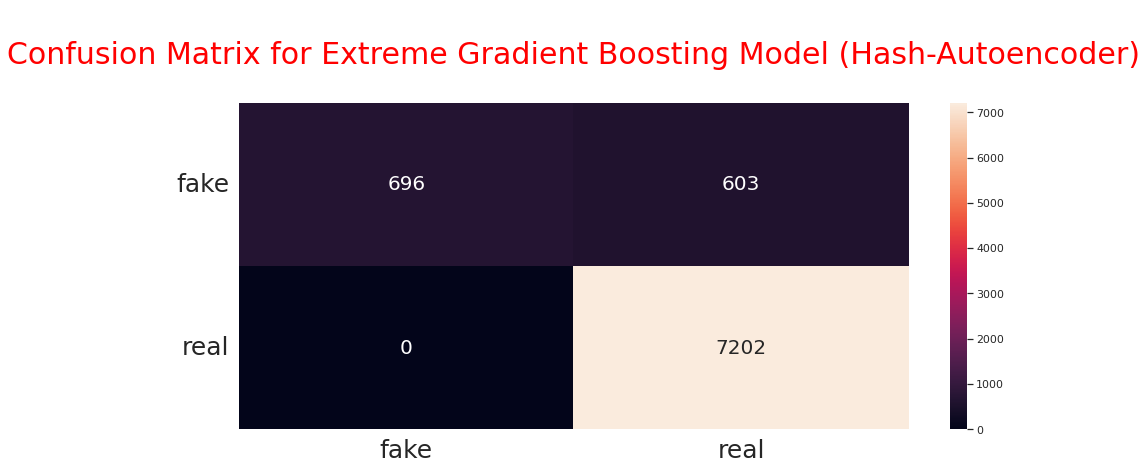

-----------------------------------------------------------------------------------------------------------------

Classification Report for:--> Extreme Gradient Boosting Model (Hash-Autoencoder) 
              precision    recall  f1-score   support

        fake       1.00      0.54      0.70      1299
        real       0.92      1.00      0.96      7202

    accuracy                           0.93      8501
   macro avg       0.96      0.77      0.83      8501
weighted avg       0.93      0.93      0.92      8501



In [ ]:
fake_precision_xgb, fake_recall_xgb, fake_f1_score_xgb=fake_news_performance(xgb_pred, 'Extreme Gradient Boosting Model')

In [ ]:
print(f'Precision, Recall and F1 Score for Fake News Classification using Extreme Gradient Boosting Model --> {fake_precision_xgb, fake_recall_xgb, fake_f1_score_xgb}, respectively')

Precision, Recall and F1 Score for Fake News Classification using Extreme Gradient Boosting Model --> (1.0, 0.54, 0.7), respectively


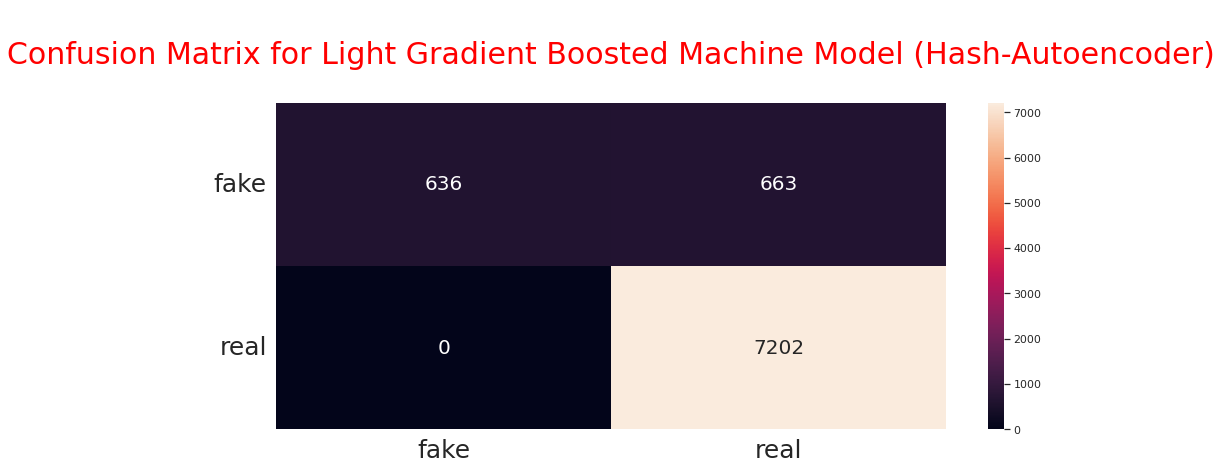

-----------------------------------------------------------------------------------------------------------------

Classification Report for:--> Light Gradient Boosted Machine Model (Hash-Autoencoder) 
              precision    recall  f1-score   support

        fake       1.00      0.49      0.66      1299
        real       0.92      1.00      0.96      7202

    accuracy                           0.92      8501
   macro avg       0.96      0.74      0.81      8501
weighted avg       0.93      0.92      0.91      8501



In [ ]:
fake_precision_lgbm, fake_recall_lgbm, fake_f1_score_lgbm=fake_news_performance(lgbm_pred, 'Light Gradient Boosted Machine Model')

In [ ]:
print(f'Precision, Recall and F1 Score for Fake News Classification using Light Gradient Boosted Machine Model --> {fake_precision_lgbm, fake_recall_lgbm, fake_f1_score_lgbm}, respectively')

Precision, Recall and F1 Score for Fake News Classification using Light Gradient Boosted Machine Model --> (1.0, 0.49, 0.66), respectively


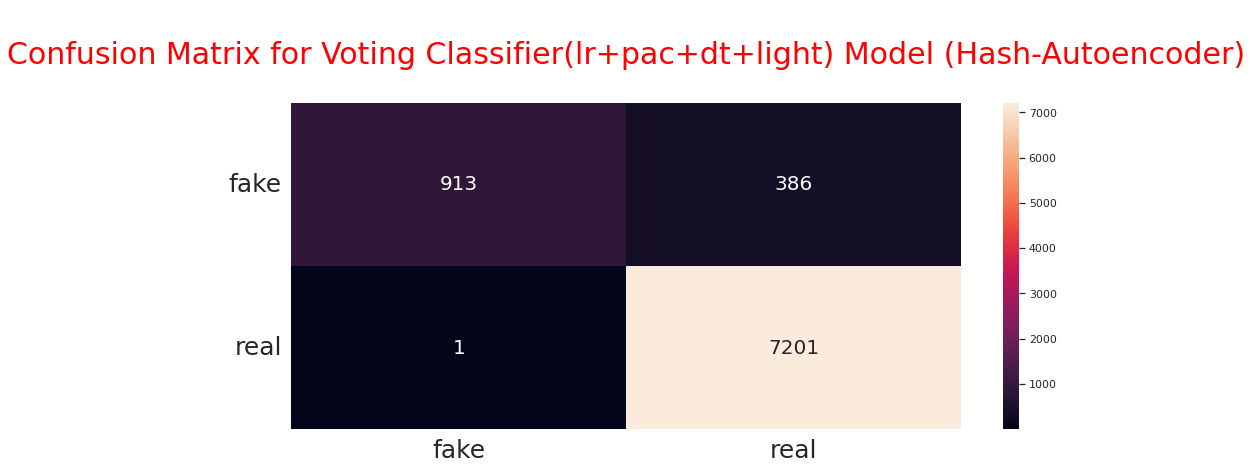

-----------------------------------------------------------------------------------------------------------------

Classification Report for:--> Voting Classifier(lr+pac+dt+light) Model (Hash-Autoencoder) 
              precision    recall  f1-score   support

        fake       1.00      0.70      0.83      1299
        real       0.95      1.00      0.97      7202

    accuracy                           0.95      8501
   macro avg       0.97      0.85      0.90      8501
weighted avg       0.96      0.95      0.95      8501



In [ ]:
fake_precision_voting, fake_recall_voting, fake_f1_score_voting=fake_news_performance(voting_pred, 'Voting Classifier(lr+pac+dt+light) Model')

In [ ]:
print(f'Precision, Recall and F1 Score for Fake News Classification using Voting Classifier(lr+pac+dt+light) Model --> {fake_precision_voting, fake_recall_voting, fake_f1_score_voting}, respectively')

Precision, Recall and F1 Score for Fake News Classification using Voting Classifier(lr+pac+dt+light) Model --> (1.0, 0.7, 0.82), respectively


In [ ]:
fake_perform={'Models Used':['Logistic Regression', 'Passive Aggressive Classifier', 'Decision Tree', 'Gradient Boosting', 'Adaptive Gradient Boosting', 'Extreme Gradient Boosting', 'Light Gradient Boosted Machine', 'Voting Classifier(lr+pac+dt+light)'],
              'Precision_fake':[fake_precision_lr, fake_precision_pac, fake_precision_dt, fake_precision_gb, fake_precision_adb, fake_precision_xgb, fake_precision_lgbm, fake_precision_voting], 
              'Recall_fake':[fake_recall_lr, fake_recall_pac, fake_recall_dt, fake_recall_gb, fake_recall_adb, fake_recall_xgb, fake_recall_lgbm, fake_recall_voting], 
              'F1-Score_fake':[fake_f1_score_lr, fake_f1_score_pac, fake_f1_score_dt, fake_f1_score_gb, fake_f1_score_adb, fake_f1_score_xgb, fake_f1_score_lgbm, fake_f1_score_voting], 
              'Overall_Accuracy':[lr_accuracy, pac_accuracy, dt_accuracy, gb_accuracy, adb_accuracy, xgb_accuracy, lgbm_accuracy, voting_accuracy]}

df_fake_perform=pd.DataFrame(fake_perform)
df_fake_perform

,Models Used,Precision_fake,Recall_fake,F1-Score_fake,Overall_Accuracy
0,Logistic Regression,0.98,0.91,0.94,0.98
1,Passive Aggressive Classifier,1.00,0.53,0.69,0.93
2,Decision Tree,0.88,0.38,0.53,0.90
3,Gradient Boosting,1.00,0.67,0.80,0.95
4,Adaptive Gradient Boosting,0.97,0.53,0.69,0.93
5,Extreme Gradient Boosting,1.00,0.54,0.70,0.93
6,Light Gradient Boosted Machine,1.00,0.49,0.66,0.92
7,Voting Classifier(lr+pac+dt+light),1.00,0.70,0.82,0.95


In [ ]:
df_fake_perform.to_csv('/content/drive/MyDrive/CSE-400(Project Thesis)/fake_news_detection_performance.csv', index=False)

In [ ]:
df_fake_perform.groupby('Models Used')['Precision_fake'].sum().sort_values(ascending=False)

Models Used
Extreme Gradient Boosting             1.00
Gradient Boosting                     1.00
Light Gradient Boosted Machine        1.00
Passive Aggressive Classifier         1.00
Voting Classifier(lr+pac+dt+light)    1.00
Logistic Regression                   0.98
Adaptive Gradient Boosting            0.97
Decision Tree                         0.88
Name: Precision_fake, dtype: float64

In [ ]:
df_fake_perform.groupby('Models Used')['Recall_fake'].sum().sort_values(ascending=False)

Models Used
Logistic Regression                   0.91
Voting Classifier(lr+pac+dt+light)    0.70
Gradient Boosting                     0.67
Extreme Gradient Boosting             0.54
Adaptive Gradient Boosting            0.53
Passive Aggressive Classifier         0.53
Light Gradient Boosted Machine        0.49
Decision Tree                         0.38
Name: Recall_fake, dtype: float64

In [ ]:
df_fake_perform.groupby('Models Used')['F1-Score_fake'].sum().sort_values(ascending=False)

Models Used
Logistic Regression                   0.94
Voting Classifier(lr+pac+dt+light)    0.82
Gradient Boosting                     0.80
Extreme Gradient Boosting             0.70
Adaptive Gradient Boosting            0.69
Passive Aggressive Classifier         0.69
Light Gradient Boosted Machine        0.66
Decision Tree                         0.53
Name: F1-Score_fake, dtype: float64

In [ ]:
df_fake_perform.set_index('Models Used', inplace=True)
df_fake_perform.sort_values('F1-Score_fake', ascending=False, inplace=True)
df_fake_perform

,Precision_fake,Recall_fake,F1-Score_fake,Overall_Accuracy
Models Used,,,,
Logistic Regression,0.98,0.91,0.94,0.98
Voting Classifier(lr+pac+dt+light),1.00,0.70,0.82,0.95
Gradient Boosting,1.00,0.67,0.80,0.95
Extreme Gradient Boosting,1.00,0.54,0.70,0.93
Passive Aggressive Classifier,1.00,0.53,0.69,0.93
Adaptive Gradient Boosting,0.97,0.53,0.69,0.93
Light Gradient Boosted Machine,1.00,0.49,0.66,0.92
Decision Tree,0.88,0.38,0.53,0.90


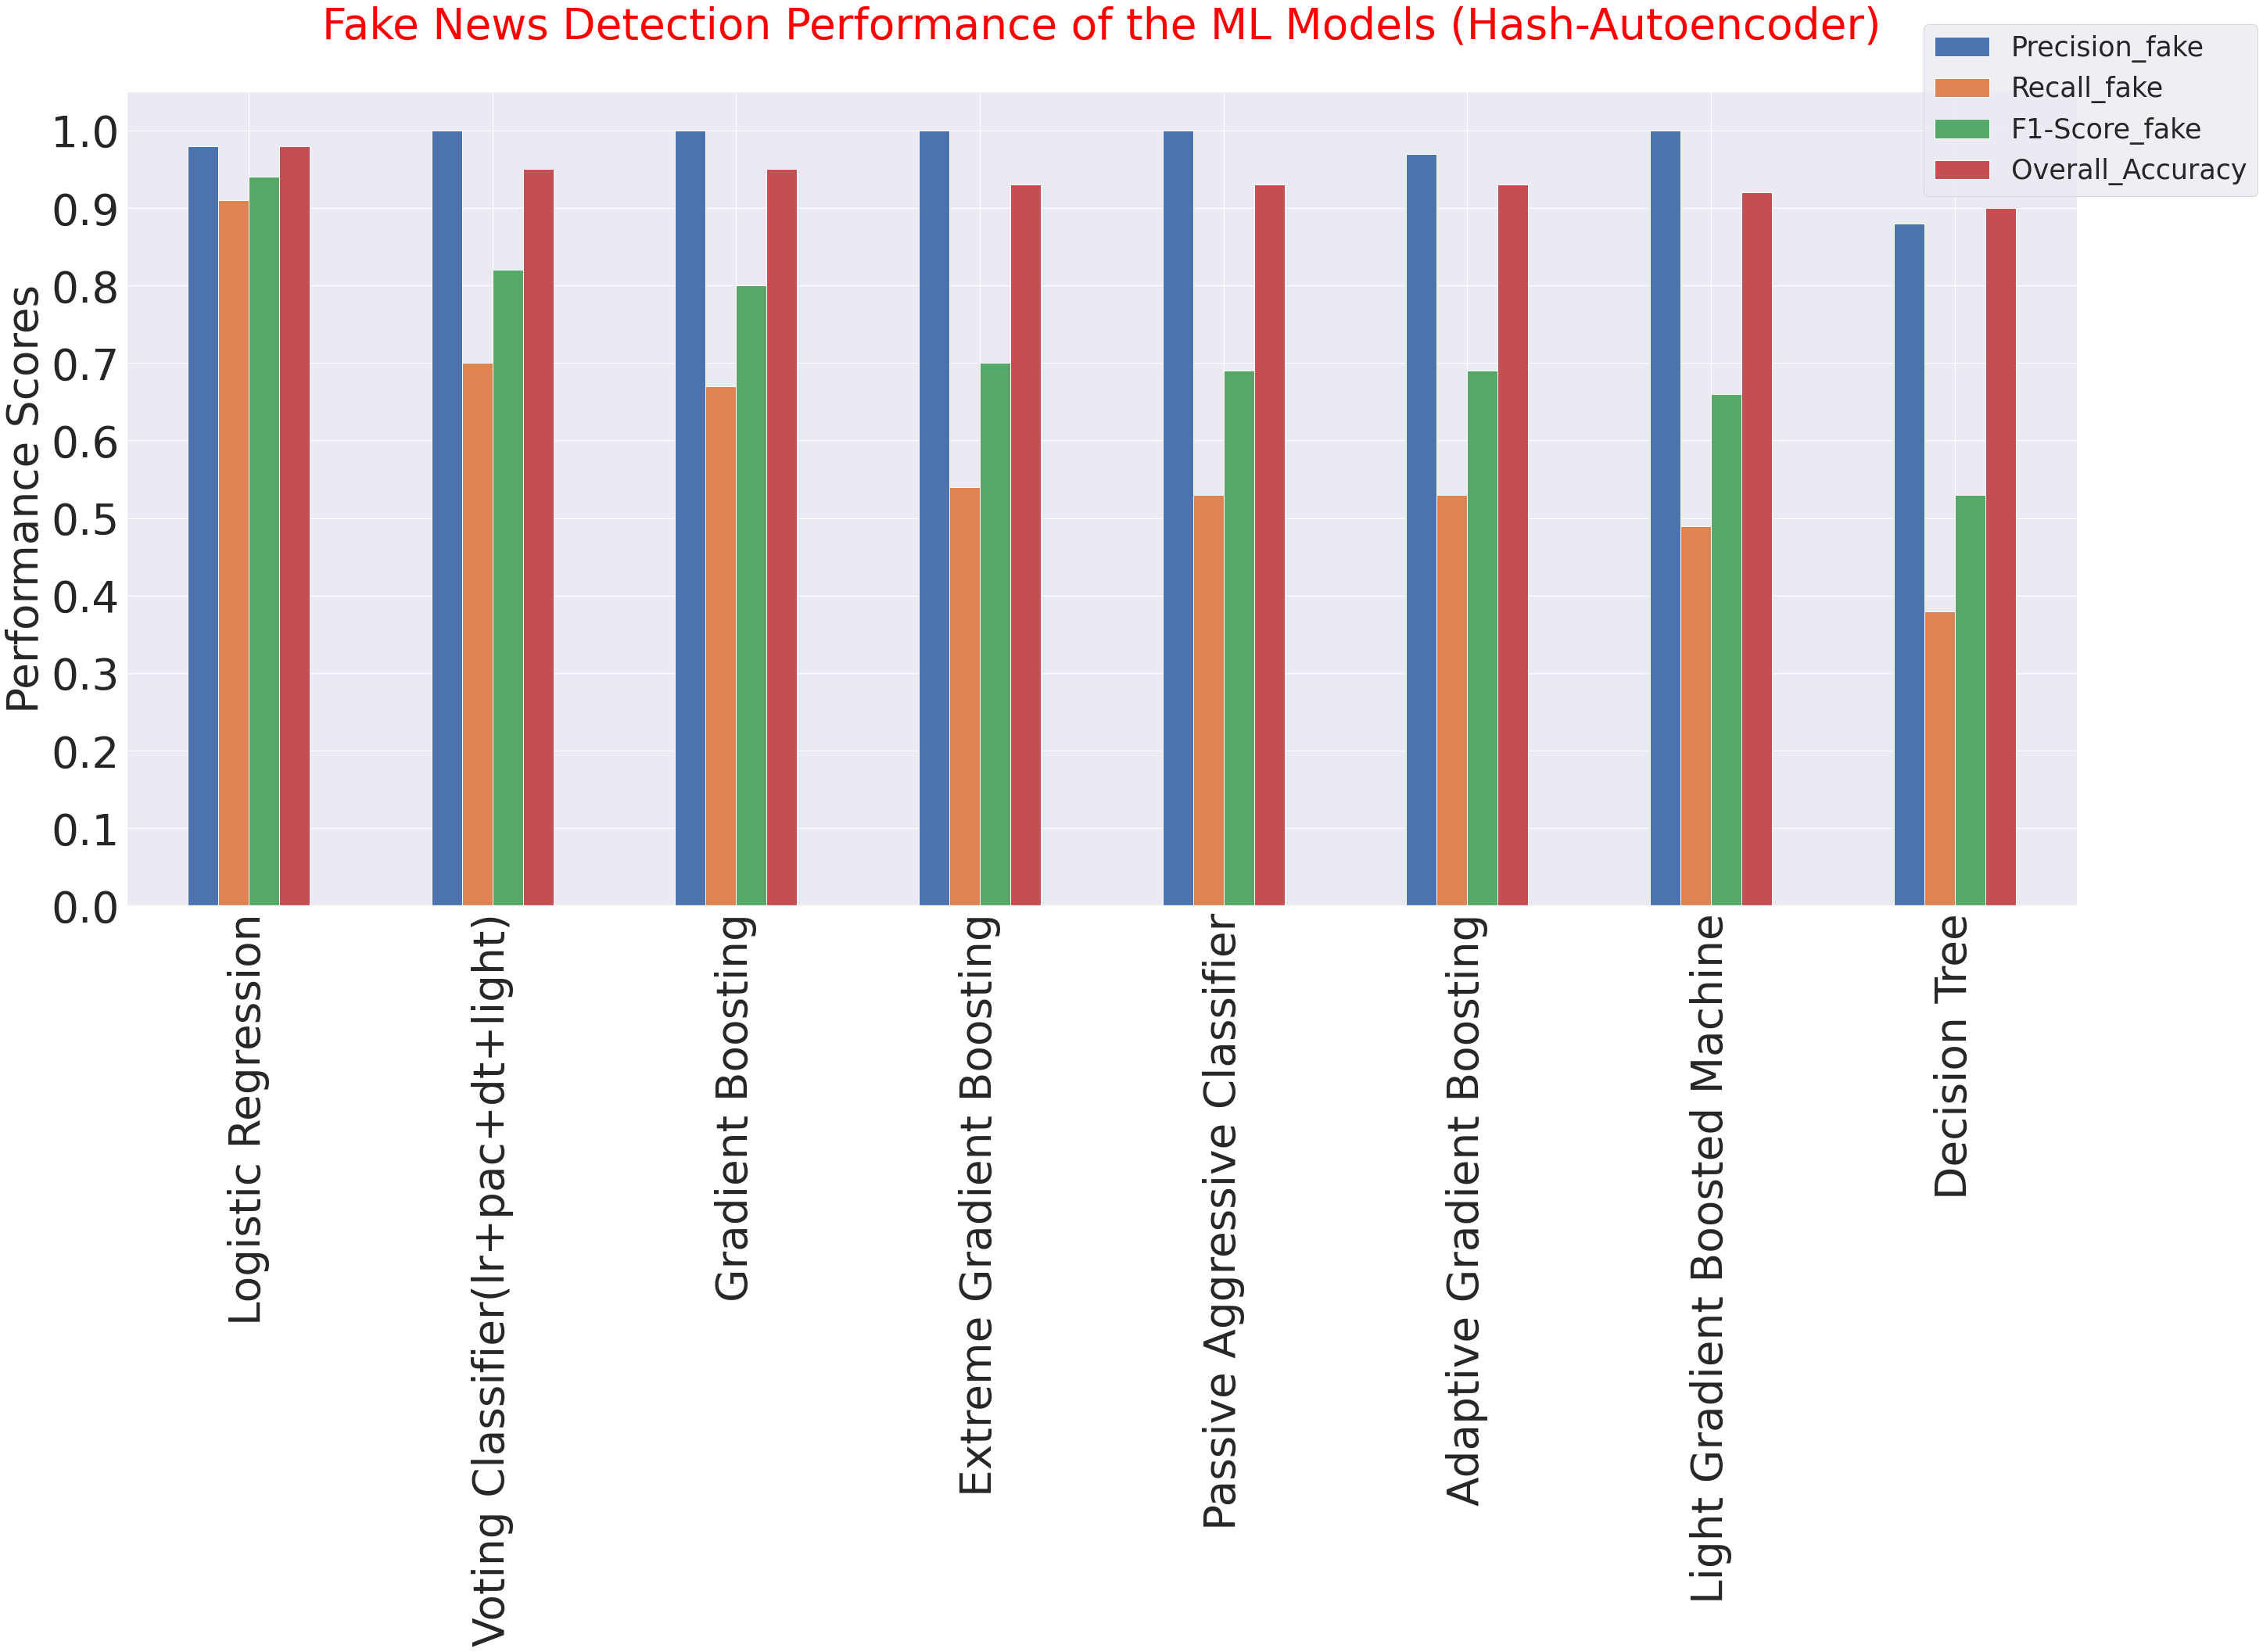

In [ ]:
df_fake_perform.plot.bar(rot=90, figsize=(40, 30));
plt.xlabel('')
plt.ylabel('Performance Scores', fontsize=55)
plt.title('Fake News Detection Performance of the ML Models (Hash-Autoencoder)\n', fontsize=55, color='red')
plt.legend(bbox_to_anchor=(1.1, 1.1), fontsize=35)
plt.yticks([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0], fontsize=55)
plt.xticks(fontsize=55)
plt.tight_layout()
plt.show()

In [ ]:
fallout_lr, sensitivity_lr, thresholds_lr=roc_curve(y, lr_pred)
fallout_pac, sensitivity_pac, thresholds_pac=roc_curve(y, pac_pred)
fallout_dt, sensitivity_dt, thresholds_dt=roc_curve(y, dt_pred)
fallout_gb, sensitivity_gb, thresholds_gb=roc_curve(y, gb_pred)
fallout_adb, sensitivity_adb, thresholds_adb=roc_curve(y, adb_pred)
fallout_xgb, sensitivity_xgb, thresholds_xgb=roc_curve(y, xgb_pred)
fallout_lgbm, sensitivity_lgbm, thresholds_lgbm=roc_curve(y, lgbm_pred)
fallout_voting, sensitivity_voting, thresholds_voting=roc_curve(y, voting_pred)

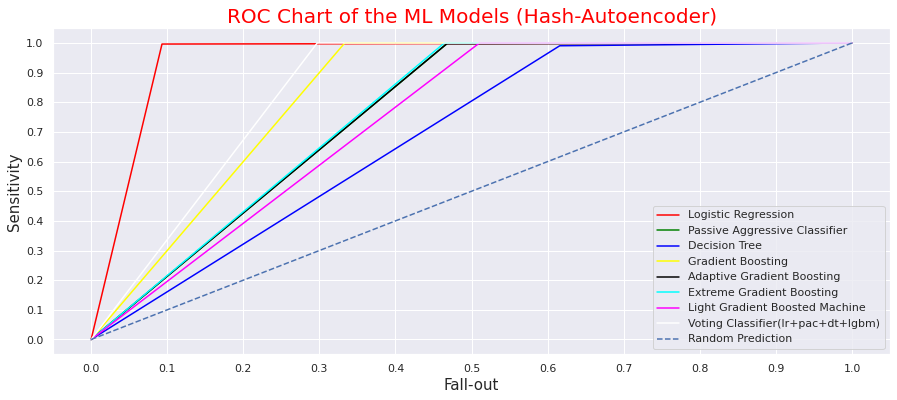

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(fallout_lr, sensitivity_lr, color='red', label='%s' % 'Logistic Regression')
plt.plot(fallout_pac, sensitivity_pac, color='green', label='%s' % 'Passive Aggressive Classifier')
plt.plot(fallout_dt, sensitivity_dt, color='blue', label='%s' % 'Decision Tree')
plt.plot(fallout_gb, sensitivity_gb, color='yellow', label='%s' % 'Gradient Boosting')
plt.plot(fallout_adb, sensitivity_adb, color='black', label='%s' % 'Adaptive Gradient Boosting')
plt.plot(fallout_xgb, sensitivity_xgb, color='cyan', label='%s' % 'Extreme Gradient Boosting')
plt.plot(fallout_lgbm, sensitivity_lgbm, color='magenta', label='%s' % 'Light Gradient Boosted Machine')
plt.plot(fallout_voting, sensitivity_voting, color='white', label='%s' % 'Voting Classifier(lr+pac+dt+lgbm)')
plt.plot([0,1], [0,1], linestyle='--', label='%s' % 'Random Prediction')
plt.title("ROC Chart of the ML Models (Hash-Autoencoder)", color='red', fontsize=20)
plt.xlabel("Fall-out", fontsize=15)
plt.ylabel("Sensitivity", fontsize=15)
plt.xticks([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0])
plt.yticks([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0])
plt.legend(loc='best')
plt.show()

In [ ]:
print("Logistic Regression AUC Score: %0.2f" % roc_auc_score(y, lr_pred))
print("Passive Aggressive Classifier AUC Score: %0.2f" % roc_auc_score(y, pac_pred))
print("Decision Tree Classifier AUC Score: %0.2f" % roc_auc_score(y, dt_pred))
print("Gradient Boosting AUC Score: %0.2f" % roc_auc_score(y, gb_pred))
print(" Adaptive Gradient Boosting AUC Score: %0.2f" % roc_auc_score(y, adb_pred))
print("Extreme Gradient Boosting AUC Score: %0.2f" % roc_auc_score(y, xgb_pred))
print(" Light Gradient Boosted Machine AUC Score: %0.2f" % roc_auc_score(y, lgbm_pred))
print("Voting Classifier(lr+pac+dt+lgbm) AUC Score: %0.2f" % roc_auc_score(y, voting_pred))

Logistic Regression AUC Score: 0.95
Passive Aggressive Classifier AUC Score: 0.77
Decision Tree Classifier AUC Score: 0.69
Gradient Boosting AUC Score: 0.83
 Adaptive Gradient Boosting AUC Score: 0.76
Extreme Gradient Boosting AUC Score: 0.77
 Light Gradient Boosted Machine AUC Score: 0.74
Voting Classifier(lr+pac+dt+lgbm) AUC Score: 0.85


In [ ]:
def model_roc_auc_score(pred):
  return roc_auc_score(y, pred)

lr_auc=model_roc_auc_score(lr_pred).round(2)
pac_auc=model_roc_auc_score(pac_pred).round(2)
dt_auc=model_roc_auc_score(dt_pred).round(2)
gb_auc=model_roc_auc_score(gb_pred).round(2)
adb_auc=model_roc_auc_score(adb_pred).round(2)
xgb_auc=model_roc_auc_score(xgb_pred).round(2)
lgbm_auc=model_roc_auc_score(lgbm_pred).round(2)
voting_auc=model_roc_auc_score(voting_pred).round(2)

auc_scores={'Models Used':['Logistic Regression', 'Passive Aggressive Classifier', 'Decision Tree', 'Gradient Boosting', 'Adaptive Gradient Boosting', 'Extreme Gradient Boosting', 'Light Gradient Boosted Machine', 'Voting Classifier(lr+pac+dt+light)'],
            'AUC':[lr_auc, pac_auc, dt_auc, gb_auc, adb_auc, xgb_auc, lgbm_auc, voting_auc]}

df_auc=pd.DataFrame(auc_scores)
df_auc

,Models Used,AUC
0,Logistic Regression,0.95
1,Passive Aggressive Classifier,0.77
2,Decision Tree,0.69
3,Gradient Boosting,0.83
4,Adaptive Gradient Boosting,0.76
5,Extreme Gradient Boosting,0.77
6,Light Gradient Boosted Machine,0.74
7,Voting Classifier(lr+pac+dt+light),0.85


In [ ]:
df_auc=df_auc.sort_values('AUC')
df_auc

,Models Used,AUC
2,Decision Tree,0.69
6,Light Gradient Boosted Machine,0.74
4,Adaptive Gradient Boosting,0.76
1,Passive Aggressive Classifier,0.77
5,Extreme Gradient Boosting,0.77
3,Gradient Boosting,0.83
7,Voting Classifier(lr+pac+dt+light),0.85
0,Logistic Regression,0.95


In [ ]:
df_auc.to_csv('/content/drive/MyDrive/CSE-400(Project Thesis)/AUC_Scores.csv', index=False)

In [ ]:
auc_df=df_auc.set_index('Models Used')
auc_df

,AUC
Models Used,
Decision Tree,0.69
Light Gradient Boosted Machine,0.74
Adaptive Gradient Boosting,0.76
Passive Aggressive Classifier,0.77
Extreme Gradient Boosting,0.77
Gradient Boosting,0.83
Voting Classifier(lr+pac+dt+light),0.85
Logistic Regression,0.95


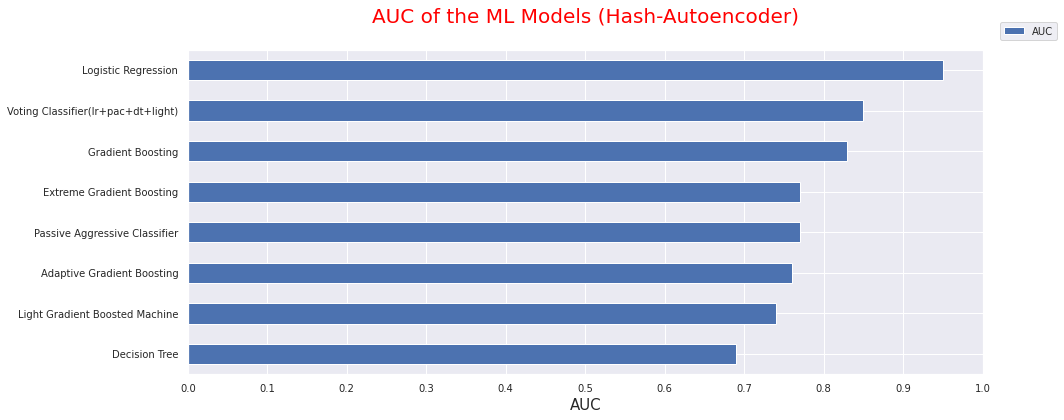

In [ ]:
auc_df.plot.barh(figsize=(15, 6));
plt.ylabel('')
plt.xlabel('AUC', fontsize=15)
plt.title('AUC of the ML Models (Hash-Autoencoder)\n', fontsize=20, color='red')
plt.legend(bbox_to_anchor=(1.1, 1.1), fontsize=10)
plt.xticks([0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0], fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()